In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
%matplotlib inline

## 查看数据
利用loadtxt读取数据文件并查看数据的分布

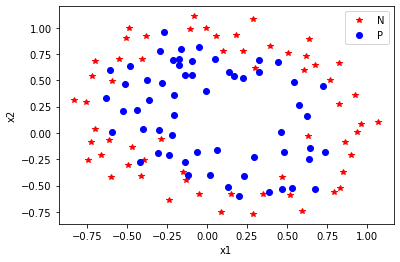

In [4]:
def show_data(filename):
    data = np.loadtxt(filename, dtype=float, delimiter=',')
    x0 = []
    y0 = []
    x1 = []
    y1 = []
    for one_node in data:
        x = one_node[0]
        y = one_node[1]
        label = int(one_node[2])
        if label == 0:
            x0.append(x)
            y0.append(y)
        elif label == 1:
            x1.append(x)
            y1.append(y)
    fig = plt.figure()
#     ax = fig.add_subplot(111)
    plt.plot(x0, y0, 'r*', label="N")
    plt.plot(x1, y1, 'bo', label="P")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(loc='upper right')
    plt.show()
    
show_data('ex2data2.txt')

## 数据分析和建模
根据数据分析可知，该数据的分布使用基本的线性逻辑回归无法构造合适的分类器，可以考虑使用椭圆来构建,椭圆的方程为:

 $\theta_{0} + \theta_{1}x1 + \theta_{2}x2 = 0$
 
 将椭圆方程转化为椭圆的一般形式， 圆心为(0, 0)，可知：
 
 $ width = 2\sqrt{|\frac{\theta_{0}}{\theta_{1}}|} $
 
 $ height = 2\sqrt{|\frac{\theta_{0}}{\theta_{2}}|} $
 
 所以问题的关键转化为如何求解$\theta$
 
本问题是一个二分类问题，即逻辑回归问题，整个问题的目的在于让概率达到最大，为了方便计算使用对数最大似然估计的方式来求解，参数的更新从原来求损失的梯度下降转化为梯度上升，详细可参考老师上课给出的PPT。
<!-- ![](https://vehicle4cm.oss-cn-beijing.aliyuncs.com/typoraimgs/1ml1.png)
![](https://vehicle4cm.oss-cn-beijing.aliyuncs.com/typoraimgs/2ml1.png)
![](https://vehicle4cm.oss-cn-beijing.aliyuncs.com/typoraimgs/3ml1.png)
![](https://vehicle4cm.oss-cn-beijing.aliyuncs.com/typoraimgs/4ml1.png)
![](https://vehicle4cm.oss-cn-beijing.aliyuncs.com/typoraimgs/5ml1.png) -->
通过PPT中给出的思路，构建模型类

In [5]:
# 用于计算f_theta(x)
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s


class LogisticRegressionModel:
    def __init__(self, x_train, y_train, alpha, x_test, y_test):
        feature_shape = x_train.shape
        feature_dim = feature_shape[1]
        feature2cal = np.ones((feature_shape[0], feature_shape[1] + 1))
        feature2cal[:, 1:] = x_train

        feature_shape_test = x_test.shape
        feature2cal_test = np.ones((feature_shape_test[0], feature_shape_test[1] + 1))
        feature2cal_test[:, 1:] = x_test

        self.x_train = feature2cal
        self.y_train = y_train
        self.x_test = feature2cal_test
        self.y_test = y_test
        self.alpha = alpha
        self.theta = np.zeros(feature_dim + 1)
        self.ln_l_theta = float("-inf")
        self.record_lns = []

    def train(self):
        epoch = 0
        while True:
            # print("epoch: {}".format(epoch))
            # 计算梯度
            ln_l_theta = 0
            gradient = 0
            for xi, yi in zip(self.x_train, self.y_train):
                t = np.matmul(self.theta, xi.T)
                # 求对数似然
                ln_l_theta = ln_l_theta + ((1-yi)*(-t) - np.log(1 + np.exp(-t)))
                gradient = gradient + ((yi - sigmoid(t)) * xi)

            # 梯度上升
            self.theta = self.theta + self.alpha * gradient
            # print("对数似然：{}".format(ln_l_theta))
            # break
            # 找到合适的终止条件，终止循环
            if (ln_l_theta - self.ln_l_theta) < 1e-6:
                break
            self.record_lns.append(ln_l_theta)
            self.ln_l_theta = ln_l_theta
            epoch = epoch + 1
        # print("theta:{}".format(self.theta))
        self.show_ln()
        return self.theta

    def show_ln(self):
        x = np.array([i+1 for i in range(len(self.record_lns))])
        plt.plot(x, self.record_lns, 'b-')
        plt.xlabel("epoch")
        plt.ylabel("ln_l_theta")
        plt.show()
        # plt.title("")
        # ax = plt.subplot(111)



    def test(self):
        # 计算, f_score
        TP_1_1 = 0
        FN_1_0 = 0
        FP_0_1 = 0
        TN_0_0 = 0
        for xi, yi in zip(self.x_test, self.y_test):
            yi = int(yi)
            t = np.matmul(self.theta, xi.T)
            sig_t = sigmoid(t)
            if sig_t < 0.5:
                y_pre = 0
            else:
                y_pre = 1

            if yi == 1 and y_pre == 1:
                TP_1_1 = TP_1_1 + 1
            elif yi == 1 and y_pre == 0:
                FN_1_0 = FN_1_0 + 1
            elif yi == 0 and y_pre == 1:
                FP_0_1 = FP_0_1 + 1
            elif yi == 0 and y_pre == 0:
                TN_0_0 = TN_0_0 + 1
        p = TP_1_1 / (TP_1_1 + FP_0_1)
        r = TP_1_1 / (TP_1_1 + FN_1_0)
        F1 = 2*p*r / (p + r)
        # print("p:{} r:{} f1-score:{}".format(p, r, F1))
        return p, r, F1

## 定义K折交叉验证，构建K折数据集

In [6]:
def k_fold_data_load(n=3):
    # 使用椭圆的数据，所以先进行平方，把数据分为n份
    data = np.loadtxt('ex2data2.txt', dtype=float, delimiter=',')
    x = data[:, 0:2]
    x = np.power(x, 2)
    y = data[:, -1]
    data_length = len(y)
    data_index = np.arange(0, data_length)
    np.random.shuffle(data_index)
    # print(data_index.shape)
    # todo 针对小数的情况做丢弃的操作
    one_fold_length = int(data_length / n)
    actual_length = one_fold_length * n
    data_index = data_index[0: actual_length]
    data_index_copy = data_index
    data_index = data_index.reshape((n, -1))

    new_data = []
    for one_fold_index in data_index:
        train_index = []
        for idx in data_index_copy:
            if idx in one_fold_index:
                pass
            else:
                train_index.append(idx)
        train_index = np.array(train_index)

        x_train = x[train_index, :]
        y_train = y[train_index]
        x_test = x[one_fold_index, :]
        y_test = y[one_fold_index]
        data_tuple = (x_train, y_train, x_test, y_test)
        new_data.append(data_tuple)

    return new_data

1 fold：


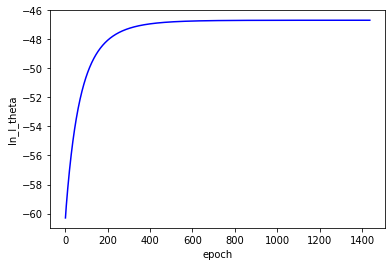

theta为[ 2.3111768  -5.36981155 -4.13541805]
p: 1.0 r: 0.6 F1: 0.75
2 fold：


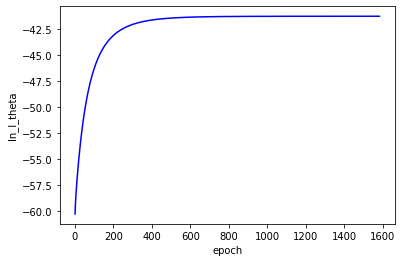

theta为[ 2.7190546  -6.71843574 -4.2545572 ]
p: 0.75 r: 0.667 F1: 0.706
3 fold：


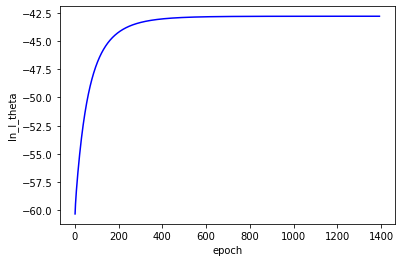

theta为[ 2.92250019 -5.94803679 -3.85393373]
p: 0.5 r: 1.0 F1: 0.667
4 fold：


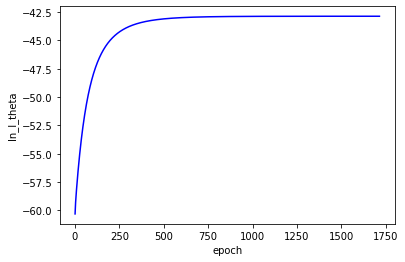

theta为[ 2.96316563 -6.59098054 -4.55383459]
p: 0.7 r: 0.824 F1: 0.757
最终结果：
theta为[ 2.7289743  -6.15681615 -4.19943589]
p: 0.738 r: 0.773 F1: 0.72


In [11]:
theta = np.array([0, 0, 0])
p = 0
r = 0
F1 = 0
new_data = k_fold_data_load(4)
k = 0
for x_train, y_train, x_test, y_test in new_data:
    print("{} fold：".format(k+1))
    model = LogisticRegressionModel(x_train, y_train, 0.01, x_test, y_test)
    k_theta = model.train()
    kp, kr, kF1 = model.test()
    print("theta为{}".format(k_theta))
    print("p: {} r: {} F1: {}".format(round(kp, 3), round(kr, 3), round(kF1, 3)))
    theta = theta + k_theta
    p = p + kp
    r = r + kr
    F1 = F1 + kF1
    k = k + 1

theta = theta / k
p = p / k
r = r / k
F1 = F1 / k
print("最终结果：")
print("theta为{}".format(theta))
print("p: {} r: {} F1: {}".format(round(p, 3), round(r, 3), round(F1, 3)))

## 计算椭圆的width和height并绘制出来

In [12]:
def show_board(theta):
    width = 2*math.sqrt(np.abs(theta[0] / theta[1]))
    height = 2*math.sqrt(np.abs(theta[0] / theta[2]))
    data = np.loadtxt('ex2data2.txt', dtype=float, delimiter=',')
    x0 = []
    y0 = []
    x1 = []
    y1 = []
    for one_node in data:
        x = one_node[0]
        y = one_node[1]
        label = int(one_node[2])
        if label == 0:
            x0.append(x)
            y0.append(y)
        elif label == 1:
            x1.append(x)
            y1.append(y)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(x0, y0, 'r*', label="N")
    plt.plot(x1, y1, 'bo', label="P")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(loc='upper right')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(loc='upper right')
    ell1 = Ellipse(xy=(0.0, 0.0), width=width, height=height, angle=0,
                   facecolor="white", edgecolor="black")
    ax.add_artist(ell1)
    plt.plot(x0, y0, 'ro')
    plt.plot(x1, y1, 'bo')
    plt.show()

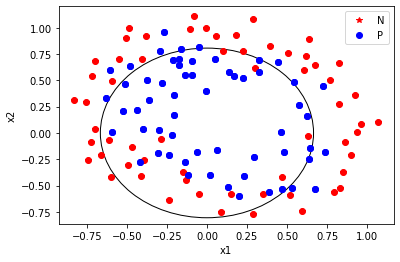

In [13]:
show_board(theta)

## TODO
1. 采用多项式进行拟合

2. 加入椭圆的角度信息

